##### Pset 2

In [1]:
import pandas as pd
import numpy as np

In [2]:
import scipy.io
mat = scipy.io.loadmat('../data/census.mat')

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
data = pd.DataFrame(np.array([mat["educ"], mat["y"], mat["yob"]]).reshape([3, 329509])).transpose()

In [5]:
data.columns = ["educ", "y", "yob"]

In [6]:
data["const"] = 1

##### Question 1

a)

##### Treatment effect - Overall

In [7]:
data.groupby("yob")["educ"].mean()

yob
30.0    0.364175
31.0    0.382794
32.0    0.388315
33.0    0.394068
34.0    0.396604
35.0    0.403167
36.0    0.405374
37.0    0.407136
38.0    0.414985
39.0    0.419746
Name: educ, dtype: float64

##### The support of the treatment probability at the cluster level is not 0 or 1.

##### Compute two estimators of the treatment effect, one using OLs and one using fixed effects

In [8]:
def get_OLS(data):
    
    X = data[["const", "educ"]].to_numpy()
    Y = data[["y"]].to_numpy()
    
    beta = np.linalg.inv(X.transpose()@X) @ X.transpose()@Y
    
    errors = Y - X @ beta

    t_pop = beta[1]
    
    return t_pop, errors, X

In [9]:
t_pop, errors, X = get_OLS(data)

In [10]:
t_pop

array([0.37765759])

In [11]:
def get_fe(data):
    
    #OLS with fixed effects
    X_fe = data.groupby("yob").apply(lambda y: y-y.mean())[["educ"]].to_numpy()
    Y_fe = data.groupby("yob").apply(lambda y: y-y.mean())[["y"]].to_numpy()
    
    beta_fe = np.linalg.inv(X_fe.transpose()@X_fe) @ X_fe.transpose()@Y_fe
    
    t_fe = beta_fe[0]
    errors_fe = Y_fe - X_fe @beta_fe

    return t_fe, errors_fe, X_fe

In [12]:
t_fe, errors_fe, X_fe = get_fe(data)

In [13]:
t_fe

array([0.37817221])

##### Using standard OLS formula for homoskedastic variance

In [14]:
(np.linalg.inv(X.transpose() @ X) * errors.var())[1,1]**0.5

0.00232455626992343

In [15]:
##### Using standard OLS formula for homoskedastic variance

In [16]:
(np.linalg.inv(X_fe.transpose() @ X_fe) * errors_fe.var())[0,0]**0.5

0.0023255642472328787

##### Neyman variance (OLS)

In [17]:
N = data.shape[0]

M = data["educ"].sum()

In [18]:
s2_T = errors[(data["educ"] == 1)].var()
s2_C = errors[(data["educ"] == 0)].var()

In [19]:
V_neyman = s2_T/(M) + s2_C/(N-M)

In [20]:
V_neyman ** 0.5

0.0023100110595997573

##### Neyman variance

In [21]:
from numpy.linalg import inv

In [22]:
# Calculate the inverse matrix once and store it
X_T_X_inv = np.linalg.inv(X.T @ X)

# Extract the squared errors vector
squared_errors = (errors ** 2)[:,0]

middle = X.T * squared_errors @ X  # Element-wise multiplication with broadcasting

# Compute the final result
V_EHW = X_T_X_inv @ middle @ X_T_X_inv


In [23]:
V_EHW[1,1]**0.5

0.0023100110595997577

##### Neyman variance (FE)

In [24]:
# Calculate the inverse matrix once and store it
X_T_X_inv_fe = np.linalg.inv(X_fe.T @ X_fe)

# Extract the squared errors vector
squared_errors_fe = (errors_fe ** 2)[:,0]

middle_fe = X_fe.T * squared_errors_fe @ X_fe  # Element-wise multiplication with broadcasting

# Compute the final result
V_EHW_fe = X_T_X_inv_fe @ middle_fe @ X_T_X_inv_fe


In [25]:
V_EHW_fe[0,0]**0.5

0.002311037801469177

b)

Bootstrap

In [26]:
n_b = 1000
#n_sample = 20000

In [27]:
from tqdm import tqdm

In [28]:
t_pop_boot = []
t_fe_boot = []
for i in tqdm(range(n_b)):
    sample = data.loc[np.random.choice(data.index, size = N, replace = True)]
    t_pop_boot.append(get_OLS(sample)[0][0])
    t_fe_boot.append(get_fe(sample)[0][0])

100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]


In [29]:
import seaborn as sns

In [30]:
import matplotlib.pyplot as plt

In [31]:
std_pop = np.std(t_pop_boot)

In [32]:
std_fe = np.std(t_fe_boot)

Text(0.38, 160, 'STD Boot:0.0023')

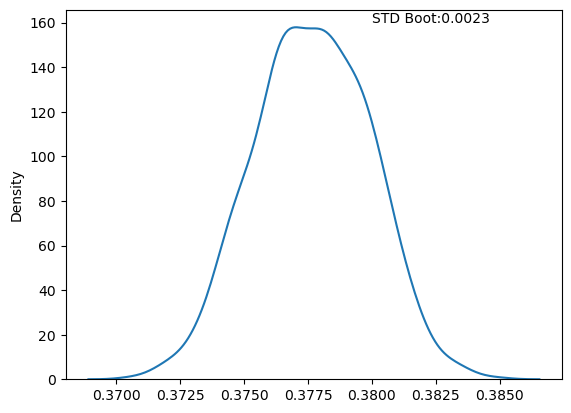

In [33]:
sns.kdeplot(t_pop_boot)
# Annotate a point
plt.annotate(
    f'STD Boot:{std_pop:.2}', # The text to display
    xy=(0.38, 160), # The point (x, y) to annotate
    xytext=(0.38, 160), # The position (x, y) to place the text
    arrowprops=None
)

Text(0.38, 160, 'STD Boot:0.0023')

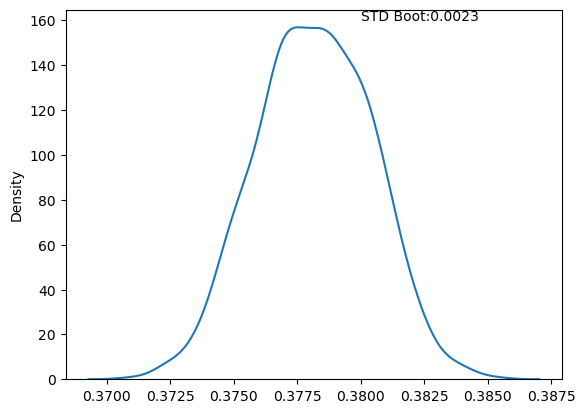

In [34]:
sns.kdeplot(t_fe_boot)
# Annotate a point
plt.annotate(
    f'STD Boot:{std_fe:.2}', # The text to display
    xy=(0.38, 160), # The point (x, y) to annotate
    xytext=(0.38, 160), # The position (x, y) to place the text
    arrowprops=None
)

c)

In [35]:
middle_cluster = np.zeros([X.shape[1], X.shape[1]])

for cluster in data["yob"].unique():
    
    X_g = X[data["yob"] == cluster,:]
    errors_g = errors[data["yob"] == cluster,:]
    middle_cluster += np.sum(X_g * errors_g, axis = 0).T @ np.sum(X_g * errors_g, axis = 0)

In [36]:
V_LZ = X_T_X_inv @ middle_cluster @ X_T_X_inv

In [37]:
V_LZ[1,1]**0.5

0.008415067653132002

In [38]:
middle_cluster_fe = np.zeros([X_fe.shape[1], X_fe.shape[1]])

for cluster in data["yob"].unique():
    
    X_g_fe = X_fe[data["yob"] == cluster,:]
    errors_g_fe = errors_fe[data["yob"] == cluster,:]
    middle_cluster_fe += np.sum(X_g_fe * errors_g_fe, axis = 0).T @ np.sum(X_g_fe * errors_g_fe, axis = 0)

In [39]:
V_LZ_fe = X_T_X_inv_fe @ middle_cluster_fe @ X_T_X_inv_fe

In [40]:
V_LZ_fe[0,0]**0.5

0.004736069280135916

d)

In [41]:
fractions = data.groupby("yob")["educ"].mean()

In [42]:
observation =  data.groupby("yob")["y"].count()

In [43]:
t_pop_boot_cl = []
t_fe_boot_cl = []

for i in tqdm(range(n_b)):
    sample = pd.DataFrame()
    for cluster in observation.index:
        
        draw_fraction = np.random.choice(fractions.values, 1)[0]
        
        N_t = observation[cluster]
        
        M_t = int(observation[cluster] * draw_fraction)
        
        sample_m = data.loc[np.random.choice(data[(data.yob == cluster) & (data.educ == 1)].index, M_t)]
        sample_nm = data.loc[np.random.choice(data[(data.yob == cluster) & (data.educ == 0)].index, N_t - M_t)]
    
        sample = pd.concat([sample, sample_m, sample_nm])
    t_pop_boot_cl.append(get_OLS(sample)[0][0])
    t_fe_boot_cl.append(get_fe(sample)[0][0])

100%|██████████| 1000/1000 [07:02<00:00,  2.37it/s]


In [44]:
np.std(t_pop_boot_cl)

0.0023302280711046757

In [45]:
np.std(t_fe_boot_cl)

0.0023197310684676064

e)

In [46]:
data_cl = data.merge(data.groupby("yob")["educ"].mean().rename("educ_cl").reset_index()).merge(data.groupby("yob")["y"].mean().rename("y_cl").reset_index())

In [47]:
data_cl["error_educ"] = data_cl["educ"] -  data_cl["educ_cl"] 
data_cl["error_y"] = data_cl["y"] -  data_cl["y_cl"] 

##### Within cluster correlation of log-earnings

In [48]:
var_y, var_y_cl, var_y_error = np.diag(data_cl[["y", "y_cl", "error_y"]].cov())

In [49]:
var_y_cl / var_y_error

2.9905755253532717e-05

f)

##### Within cluster correlation of log-earnings

In [50]:
var_t, var_t_cl, var_t_error = np.diag(data_cl[["educ", "educ_cl", "error_educ"]].cov())

In [51]:
var_t_cl / var_t_error

0.0010352893575185649

g) We could report the clausal cluster variance

##### Question 2

a)

I would report the EHW.

b)

In [52]:
fractions


yob
30.0    0.364175
31.0    0.382794
32.0    0.388315
33.0    0.394068
34.0    0.396604
35.0    0.403167
36.0    0.405374
37.0    0.407136
38.0    0.414985
39.0    0.419746
Name: educ, dtype: float64

In [53]:
fractions.mean()

0.3976363242160999

In [54]:
fractions.mean() * (1-fractions.mean()) ** 0.5

0.30861386806538577

In [55]:
fractions.var()

0.0002679053097953354

This because the variance of $A_{k, g}$ is close to 0. At most I'd use the CCV. The clustered adjusted variance seems to be an overadjustment for the standard errors.